Balanced class counts:
 label
2    154
1    154
0    154
Name: count, dtype: int64
Iteration 1, loss = 1.12029332
Validation score: 0.608108
Iteration 2, loss = 1.02182414
Validation score: 0.756757
Iteration 3, loss = 0.93003624
Validation score: 0.864865
Iteration 4, loss = 0.84935609
Validation score: 0.932432
Iteration 5, loss = 0.77622719
Validation score: 0.972973
Iteration 6, loss = 0.71048267
Validation score: 0.986486
Iteration 7, loss = 0.65282462
Validation score: 0.986486
Iteration 8, loss = 0.60083323
Validation score: 0.986486
Iteration 9, loss = 0.55442975
Validation score: 0.986486
Iteration 10, loss = 0.51272765
Validation score: 0.986486
Iteration 11, loss = 0.47425861
Validation score: 0.986486
Iteration 12, loss = 0.43982023
Validation score: 0.986486
Iteration 13, loss = 0.40851468
Validation score: 0.986486
Iteration 14, loss = 0.37962105
Validation score: 0.986486
Iteration 15, loss = 0.35317219
Validation score: 0.986486
Iteration 16, loss = 0.32827903
Validatio

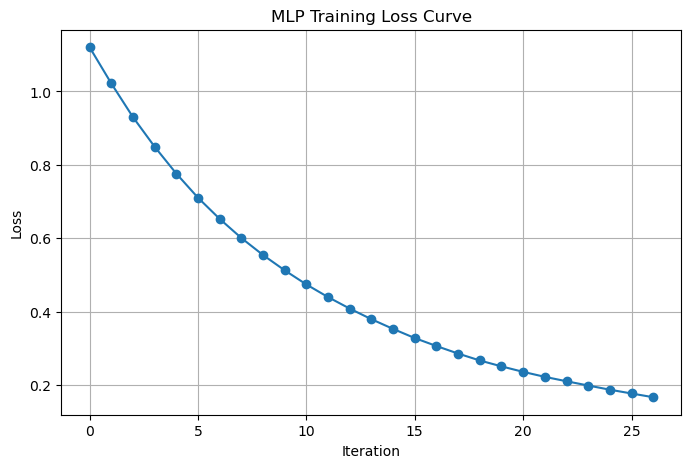

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

# --- Original soil data ---
soil_data = pd.DataFrame({
    'Gravel': [24.1, 9.8, 14.0, 7.5, 30.0, 15.0, 40.0],
    'Sand': [74.8, 89.1, 85.4, 91.6, 65.0, 80.0, 55.0],
    'Fines': [1.2, 1.0, 0.6, 0.9, 5.0, 4.5, 5.0],
    'D10': [0.22, 0.30, 0.20, 0.20, 0.15, 0.25, 0.10],
    'D30': [0.48, 0.50, 0.32, 0.40, 0.35, 0.45, 0.25],
    'D50': [0.90, 0.70, 0.60, 0.60, 0.50, 0.60, 0.40],
    'D60': [2.00, 1.00, 0.8, 0.90, 1.50, 1.80, 0.70],
    'Cu': [9.09, 3.33, 4.00, 4.50, 10.0, 7.2, 7.0],
    'Cc': [0.52, 0.83, 0.64, 0.89, 1.0, 1.1, 1.2],
    'Gs': [2.5, 2.7, 2.5, 2.5, 2.6, 2.65, 2.55],
    'USCS': ['SW', 'SW', 'SW', 'SW', 'SP', 'SP', 'GP']
})

# Encode soil class labels
label_encoder = LabelEncoder()
soil_data['label'] = label_encoder.fit_transform(soil_data['USCS'])

# Generate synthetic data using Gaussian sampling per class
def generate_gaussian_synthetic(data, n_samples_per_class=150):
    synth_samples = []
    np.random.seed(42)
    for label in data['label'].unique():
        subset = data[data['label'] == label]
        features = subset.columns.drop(['USCS', 'label'])
        means = subset[features].mean()
        stds = subset[features].std().replace(0, 0.01)
        for _ in range(n_samples_per_class):
            sample = np.random.normal(loc=means, scale=stds)
            sample = pd.Series(sample, index=features)
            # Clip to original data min/max to keep realistic values
            for f in features:
                sample[f] = np.clip(sample[f], data[f].min(), data[f].max())
            d = sample.to_dict()
            d['label'] = label
            synth_samples.append(d)
    return pd.DataFrame(synth_samples)

synth_df = generate_gaussian_synthetic(soil_data, 150)

# Combine original and synthetic data
combined_df = pd.concat([soil_data.drop(columns=['USCS']), synth_df], ignore_index=True)
combined_df.fillna(combined_df.mean(), inplace=True)

# Features and targets
X = combined_df.drop('label', axis=1)
y = combined_df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("Balanced class counts:\n", pd.Series(y_res).value_counts())

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Initialize and train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.2,
                    n_iter_no_change=20,
                    verbose=True)

mlp.fit(X_train, y_train)

# Predict on validation set
y_val_pred = mlp.predict(X_val)

# Classification report
print("\nClassification report:\n", classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# Regression metrics treating labels as numeric (optional)
y_val_numeric = y_val.astype(float)
y_val_pred_numeric = y_val_pred.astype(float)

r2 = r2_score(y_val_numeric, y_val_pred_numeric)
mae = mean_absolute_error(y_val_numeric, y_val_pred_numeric)
mse = mean_squared_error(y_val_numeric, y_val_pred_numeric)

print("\nRegression metrics on validation set (treating labels as numeric):")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")

# Plot training loss curve
plt.figure(figsize=(8,5))
plt.plot(mlp.loss_curve_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.grid(True)
plt.show()


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Set up Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1s = []

fold = 1
for train_index, val_index in kf.split(X_res, y_res):
    X_train_cv, X_val_cv = X_res[train_index], X_res[val_index]
    y_train_cv, y_val_cv = y_res[train_index], y_res[val_index]
    
    # Initialize MLP model (same config as before)
    mlp_cv = MLPClassifier(hidden_layer_sizes=(100, 50),
                           activation='relu',
                           solver='adam',
                           max_iter=500,
                           random_state=42,
                           early_stopping=True,
                           validation_fraction=0.2,
                           n_iter_no_change=20,
                           verbose=False)
    
    mlp_cv.fit(X_train_cv, y_train_cv)
    
    y_val_pred_cv = mlp_cv.predict(X_val_cv)
    
    acc = accuracy_score(y_val_cv, y_val_pred_cv)
    prec = precision_score(y_val_cv, y_val_pred_cv, average='macro', zero_division=0)
    rec = recall_score(y_val_cv, y_val_pred_cv, average='macro')
    f1 = f1_score(y_val_cv, y_val_pred_cv, average='macro')
    
    print(f"Fold {fold} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
    fold += 1

print("\n=== Cross-validation results (5 folds) ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"Mean F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


Fold 1 - Accuracy: 0.9892, Precision: 0.9896, Recall: 0.9892, F1-score: 0.9892
Fold 2 - Accuracy: 0.9892, Precision: 0.9896, Recall: 0.9892, F1-score: 0.9892
Fold 3 - Accuracy: 0.9891, Precision: 0.9896, Recall: 0.9892, F1-score: 0.9892
Fold 4 - Accuracy: 0.9783, Precision: 0.9792, Recall: 0.9785, F1-score: 0.9783
Fold 5 - Accuracy: 0.9891, Precision: 0.9896, Recall: 0.9889, F1-score: 0.9891

=== Cross-validation results (5 folds) ===
Mean Accuracy: 0.9870 ± 0.0044
Mean Precision: 0.9875 ± 0.0042
Mean Recall: 0.9870 ± 0.0043
Mean F1-score: 0.9870 ± 0.0044


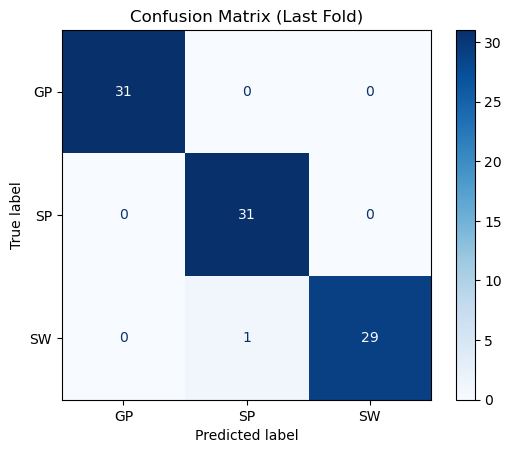

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example: Confusion matrix for last fold
cm = confusion_matrix(y_val_cv, y_val_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Last Fold)")
plt.show()


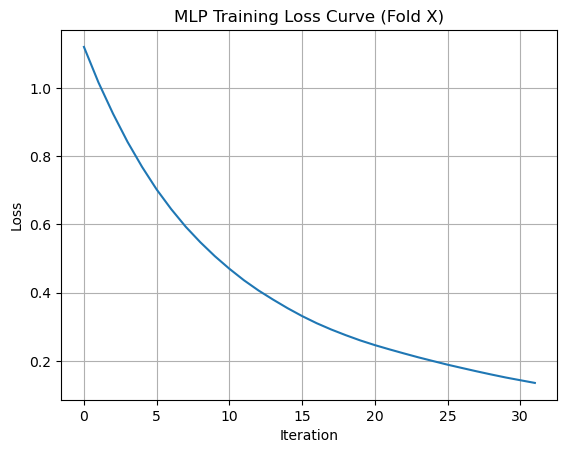

In [4]:
plt.plot(mlp_cv.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve (Fold X)')
plt.grid(True)
plt.show()


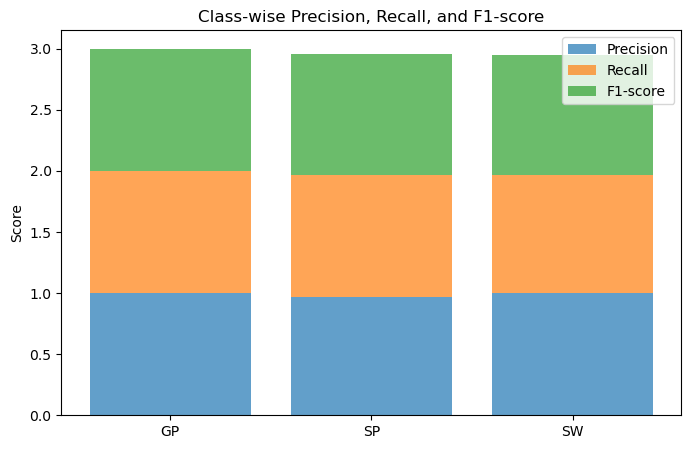

In [5]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_val_cv, y_val_pred_cv, average=None)
classes = label_encoder.classes_

plt.figure(figsize=(8,5))
plt.bar(classes, precision, alpha=0.7, label='Precision')
plt.bar(classes, recall, alpha=0.7, label='Recall', bottom=precision)
plt.bar(classes, f1, alpha=0.7, label='F1-score', bottom=precision+recall)
plt.ylabel('Score')
plt.title('Class-wise Precision, Recall, and F1-score')
plt.legend()
plt.show()


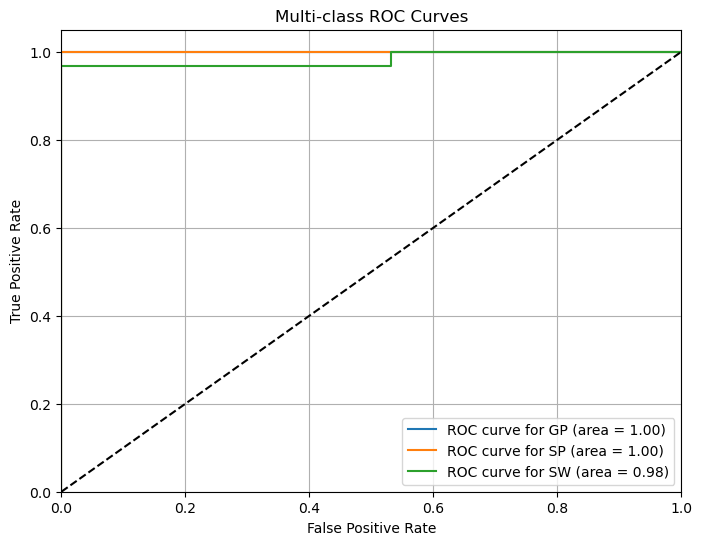

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for ROC (required for multiclass)
y_val_bin = label_binarize(y_val_cv, classes=np.unique(y_res))
y_pred_prob = mlp_cv.predict_proba(X_val_cv)

plt.figure(figsize=(8,6))
for i, class_label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_label} (area = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


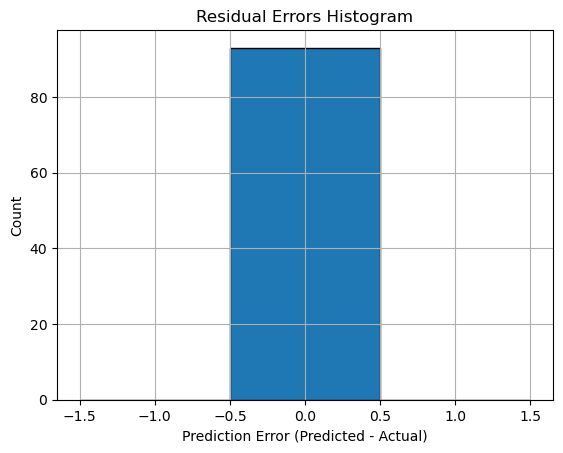

In [7]:
errors = y_val_pred_numeric - y_val_numeric
plt.hist(errors, bins=np.arange(-1.5, 2.5, 1), edgecolor='black')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residual Errors Histogram')
plt.grid(True)
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (100,50), (150,75,25)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [1e-4, 1e-3, 1e-2],  # L2 penalty
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],
}

mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.2, n_iter_no_change=20)

random_search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_res, y_res)

print("Best parameters found:")
print(random_search.best_params_)
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'solver': 'sgd', 'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}
Best cross-validation accuracy: 0.9978


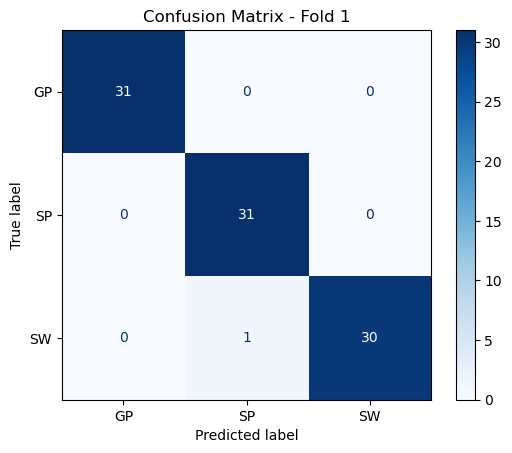

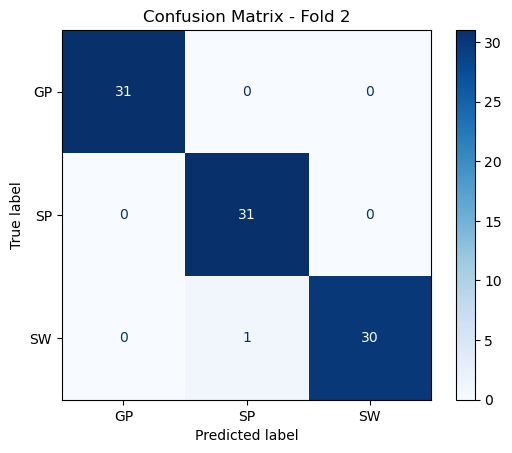

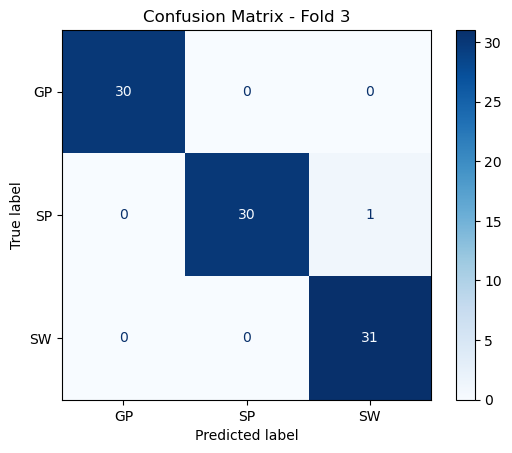

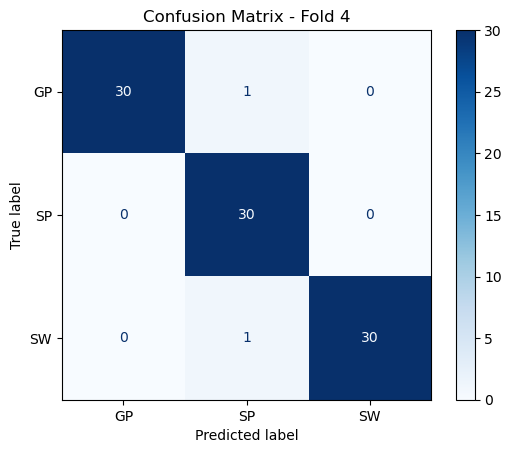

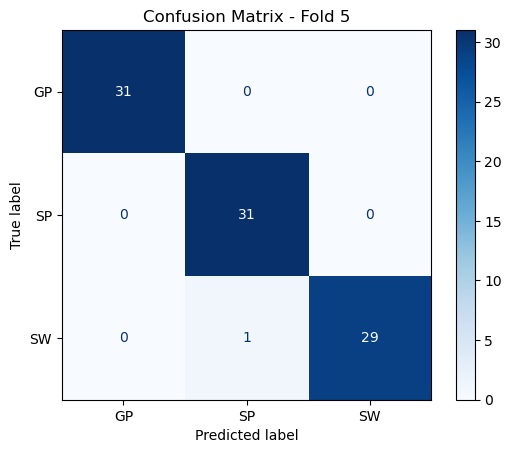

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_idx, val_idx in kf.split(X_res, y_res):
    X_train_cv, X_val_cv = X_res[train_idx], X_res[val_idx]
    y_train_cv, y_val_cv = y_res[train_idx], y_res[val_idx]

    mlp_cv = MLPClassifier(hidden_layer_sizes=(100, 50),
                           activation='relu',
                           solver='adam',
                           max_iter=500,
                           random_state=42,
                           early_stopping=True,
                           validation_fraction=0.2,
                           n_iter_no_change=20,
                           verbose=False)
    mlp_cv.fit(X_train_cv, y_train_cv)
    y_val_pred_cv = mlp_cv.predict(X_val_cv)

    cm = confusion_matrix(y_val_cv, y_val_pred_cv)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.show()

    fold += 1


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# One-hot encode labels for TF
num_classes = len(label_encoder.classes_)
y_res_cat = to_categorical(y_res, num_classes)

# Define model architecture
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_res.shape[1],)),
    Dense(50, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model with validation split and early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_res, y_res_cat,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on hold-out validation set if you want (split before training)


C:\Users\Vision\anaconda3\envs\soil-nn-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
12/12 - 2s - 142ms/step - accuracy: 0.6179 - loss: 0.8621 - val_accuracy: 0.0215 - val_loss: 1.1120
Epoch 2/500
12/12 - 0s - 12ms/step - accuracy: 0.8157 - loss: 0.4605 - val_accuracy: 0.0215 - val_loss: 1.1175
Epoch 3/500
12/12 - 0s - 11ms/step - accuracy: 0.8211 - loss: 0.3167 - val_accuracy: 0.0215 - val_loss: 1.1004
Epoch 4/500
12/12 - 0s - 12ms/step - accuracy: 0.8238 - loss: 0.2618 - val_accuracy: 0.0215 - val_loss: 1.0769
Epoch 5/500
12/12 - 0s - 12ms/step - accuracy: 0.8618 - loss: 0.2358 - val_accuracy: 1.0000 - val_loss: 1.0483
Epoch 6/500
12/12 - 0s - 12ms/step - accuracy: 0.9973 - loss: 0.2198 - val_accuracy: 1.0000 - val_loss: 1.0173
Epoch 7/500
12/12 - 0s - 11ms/step - accuracy: 0.9973 - loss: 0.2071 - val_accuracy: 1.0000 - val_loss: 0.9870
Epoch 8/500
12/12 - 0s - 11ms/step - accuracy: 0.9973 - loss: 0.1959 - val_accuracy: 1.0000 - val_loss: 0.9557
Epoch 9/500
12/12 - 0s - 10ms/step - accuracy: 0.9973 - loss: 0.1867 - val_accuracy: 1.0000 - val_loss: 0.9174


In [11]:
def predict_soil_class(new_samples_df, scaler, trained_model, label_encoder):
    """
    new_samples_df: pd.DataFrame of new soil feature samples (same columns as training features)
    scaler: fitted StandardScaler object
    trained_model: your trained sklearn MLPClassifier
    label_encoder: fitted LabelEncoder for soil classes
    """
    X_new = new_samples_df.copy()
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    # Predict class labels (integers)
    pred_labels = trained_model.predict(X_new_scaled)
    # Decode to original soil classes
    pred_classes = label_encoder.inverse_transform(pred_labels)
    return pred_classes

# Usage example:
# new_data = pd.DataFrame({...})
# predictions = predict_soil_class(new_data, scaler, mlp, label_encoder)
# print(predictions)


In [12]:
def predict_soil_class(new_samples_df, scaler, trained_model, label_encoder):
    X_new_scaled = scaler.transform(new_samples_df)
    pred_labels = trained_model.predict(X_new_scaled)
    pred_classes = label_encoder.inverse_transform(pred_labels)
    return pred_classes


# Example usage:
new_data = pd.DataFrame({
    'Gravel': [20.0, 35.0],
    'Sand': [75.0, 60.0],
    'Fines': [5.0, 5.0],
    'D10': [0.18, 0.12],
    'D30': [0.40, 0.30],
    'D50': [0.55, 0.45],
    'D60': [1.20, 0.80],
    'Cu': [6.0, 8.0],
    'Cc': [0.85, 1.0],
    'Gs': [2.6, 2.55]
})

predictions = predict_soil_class(new_data, scaler, final_mlp, label_encoder)
print(predictions)


NameError: name 'final_mlp' is not defined

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier

# --- Sample original soil data ---
soil_data = pd.DataFrame({
    'Gravel': [24.1, 9.8, 14.0, 7.5, 30.0, 15.0, 40.0],
    'Sand': [74.8, 89.1, 85.4, 91.6, 65.0, 80.0, 55.0],
    'Fines': [1.2, 1.0, 0.6, 0.9, 5.0, 4.5, 5.0],
    'D10': [0.22, 0.30, 0.20, 0.20, 0.15, 0.25, 0.10],
    'D30': [0.48, 0.50, 0.32, 0.40, 0.35, 0.45, 0.25],
    'D50': [0.90, 0.70, 0.60, 0.60, 0.50, 0.60, 0.40],
    'D60': [2.00, 1.00, 0.8, 0.90, 1.50, 1.80, 0.70],
    'Cu': [9.09, 3.33, 4.00, 4.50, 10.0, 7.2, 7.0],
    'Cc': [0.52, 0.83, 0.64, 0.89, 1.0, 1.1, 1.2],
    'Gs': [2.5, 2.7, 2.5, 2.5, 2.6, 2.65, 2.55],
    'USCS': ['SW', 'SW', 'SW', 'SW', 'SP', 'SP', 'GP']
})

# Encode labels
label_encoder = LabelEncoder()
soil_data['label'] = label_encoder.fit_transform(soil_data['USCS'])

# Features and labels
X = soil_data.drop(columns=['USCS', 'label'])
y = soil_data['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train MLP with best parameters (example from your tuning)
final_mlp = MLPClassifier(
    solver='sgd',
    max_iter=500,
    learning_rate_init=0.01,
    hidden_layer_sizes=(100,),
    alpha=0.0001,
    activation='relu',
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    verbose=True
)
final_mlp.fit(X_scaled, y)

# Prediction function
def predict_soil_class(new_samples_df, scaler, trained_model, label_encoder):
    X_new_scaled = scaler.transform(new_samples_df)
    pred_labels = trained_model.predict(X_new_scaled)
    pred_classes = label_encoder.inverse_transform(pred_labels)
    return pred_classes

# New soil samples for prediction
new_data = pd.DataFrame({
    'Gravel': [20.0, 35.0],
    'Sand': [75.0, 60.0],
    'Fines': [5.0, 5.0],
    'D10': [0.18, 0.12],
    'D30': [0.40, 0.30],
    'D50': [0.55, 0.45],
    'D60': [1.20, 0.80],
    'Cu': [6.0, 8.0],
    'Cc': [0.85, 1.0],
    'Gs': [2.6, 2.55]
})

predictions = predict_soil_class(new_data, scaler, final_mlp, label_encoder)
print(predictions)


Iteration 1, loss = 1.39451620
Validation score: 0.500000
Iteration 2, loss = 1.32450797
Validation score: 0.500000
Iteration 3, loss = 1.23131813
Validation score: 0.500000
Iteration 4, loss = 1.12268198
Validation score: 1.000000
Iteration 5, loss = 1.00744137
Validation score: 1.000000
Iteration 6, loss = 0.89179689
Validation score: 1.000000
Iteration 7, loss = 0.78125162
Validation score: 1.000000
Iteration 8, loss = 0.68073154
Validation score: 1.000000
Iteration 9, loss = 0.59158219
Validation score: 1.000000
Iteration 10, loss = 0.51480313
Validation score: 1.000000
Iteration 11, loss = 0.44931212
Validation score: 1.000000
Iteration 12, loss = 0.39285636
Validation score: 1.000000
Iteration 13, loss = 0.34437931
Validation score: 1.000000
Iteration 14, loss = 0.30251137
Validation score: 1.000000
Iteration 15, loss = 0.26594294
Validation score: 1.000000
Iteration 16, loss = 0.23412984
Validation score: 1.000000
Iteration 17, loss = 0.20706267
Validation score: 1.000000
Iterat